In [1]:
import pyro
import torch
from torch import nn
from pyro.infer import SVI, Trace_ELBO

# standard import
import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import seaborn as sns

In [2]:
"""
Torch/Pyro Implementation of (Unconditional) Normalizing Flow. In particular, as seen in RealNVP (z = x * exp(s) + t), where half of the 
dimensions in x are linearly scaled/transfromed as a function of the other half.
"""
import pyro
import torch
from torch import nn
from pyro.nn import DenseNN
import pyro.distributions as dist
from pyro.distributions.transforms import permute, BatchNorm
from pyro.distributions.transforms.affine_coupling import AffineCoupling
import itertools

class NormalizingFlow(nn.Module):
    """
    
    """
    def __init__(self, input_dim=2, split_dim=1, hidden_dim=128, num_layers=1, flow_length=10, 
                use_cuda=False):
        super(NormalizingFlow, self).__init__()
        self.base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim)) # base distribution is Isotropic Gaussian
        self.param_dims = [input_dim-split_dim, input_dim-split_dim]
        # Define series of bijective transformations
        self.transforms = [AffineCoupling(split_dim, DenseNN(split_dim, [hidden_dim]*num_layers, self.param_dims)) for _ in range(flow_length)]
        self.perms = [permute(2, torch.tensor([1,0])) for _ in range(flow_length)]
        # Concatenate AffineCoupling layers with Permute Layers
        self.generative_flows = list(itertools.chain(*zip(self.transforms, self.perms)))[:-1] # generative direction (z-->x)
        self.normalizing_flows = self.generative_flows[::-1] # normalizing direction (x-->z)
        self.flow_dist = dist.TransformedDistribution(self.base_dist, self.generative_flows)
        
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()
            nn.ModuleList(self.transforms).cuda()
            self.base_dist = dist.Normal(torch.zeros(input_dim).cuda(),
                                         torch.ones(input_dim).cuda())
    
    def model(self, X=None):
        N = len(X) if X is not None else None
        pyro.module("nf", nn.ModuleList(self.transforms))
        with pyro.plate("data", N):
                obs = pyro.sample("obs", self.flow_dist, obs=X)
            
    def guide(self, X=None):
        pass
    
    def forward(self, z):
        zs = [z]
        for flow in self.generative_flows:
            z_i = flow(zs[-1])
            zs.append(z_i)
        return zs, z_i
    
    def backward(self, x):
        zs = [x]
        for flow in self.normalizing_flows:
            z_i = flow._inverse(zs[-1])
            zs.append(z_i)
        return zs, z_i
    
    def sample(self, num_samples):
        z_0_samples = self.base_dist.sample([num_samples])
        zs, x = self.forward(z_0_samples)
        return x
    
    def log_prob(self, x):
        return self.flow_dist.log_prob(x)
    
    def parameters(self):
        return nn.ModuleList([m for m in self.transforms if isinstance(m, nn.Module)]).parameters()


In [3]:
from data.m1m2 import load_data

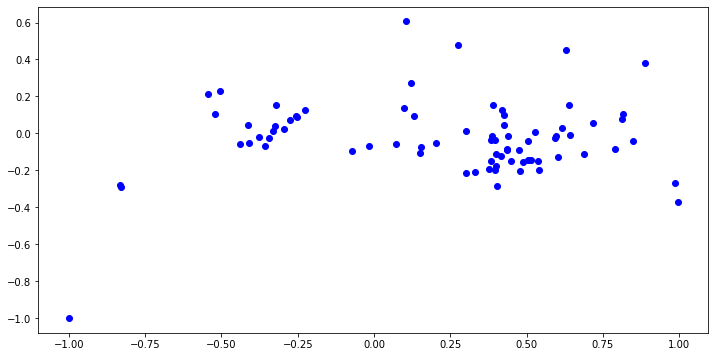

In [4]:
n = 1000
X = load_data('../../datasets/Combined_GWTC_m1m2chieffz.npz')

X_tensor = torch.stack(X, dim=-1)

X_tensor[:, :, 0] = X_tensor[:, :, 0].clamp(4.59, 86.22)
X_tensor[:, :, 1] = X_tensor[:, :, 1].clamp(4.59, 86.22)

X_tensor[:, :, 1] = X_tensor[:, :, 0] / X_tensor[:, :, 1] - 1 + 1e-2
X_tensor = X_tensor.log()
# X_tensor[:, :, 1] = X_tensor[:, :, 1].log()
# # X_tensor[:, :, 1] = X_tensor[:, :, 1].clamp(0.1)

min = X_tensor.view(-1, 2).min(dim=0, keepdim=True)[0]
max = X_tensor.view(-1, 2).max(dim=0, keepdim=True)[0]

X_tensor = (1 - -1) * ((X_tensor - min) / (max - min)) + -1

X_plot = X_tensor.mean(dim=1)

plt.figure(figsize=(12,6))
plt.scatter(X_plot[:, 0], X_plot[:, 1], c="b")
plt.show()


In [5]:
X_tensor[:, :, 1]

tensor([[-0.2233, -0.2291, -0.7356,  ..., -0.1200, -0.2588, -0.2516],
        [ 0.1933,  0.4296,  0.0507,  ...,  0.5096,  0.1051, -0.1356],
        [ 0.0829,  0.0649, -0.1260,  ...,  0.2832,  0.4758, -0.1707],
        ...,
        [ 0.0568,  0.2232,  0.3159,  ...,  0.4071,  0.1838,  0.2893],
        [ 0.0104, -0.7812,  0.0281,  ..., -0.6180, -0.1506, -0.4514],
        [ 0.4455, -0.0254,  0.5198,  ..., -0.1116,  0.2440,  0.2827]])

<AxesSubplot:ylabel='Density'>

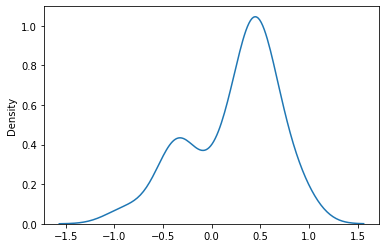

In [6]:
sns.kdeplot(X_plot[:, 0])

<AxesSubplot:ylabel='Density'>

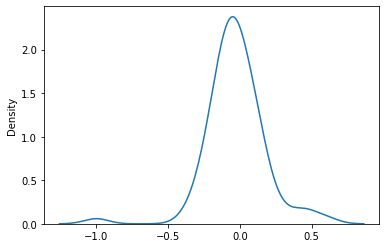

In [7]:
sns.kdeplot(X_plot[:, 1])

In [8]:
dataset = torch.utils.data.TensorDataset(X_tensor)

In [9]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024,
                        shuffle=True, num_workers=0)


In [10]:
flow = NormalizingFlow(input_dim=2, split_dim=1, hidden_dim=32, num_layers=1, flow_length=8, 
                    use_cuda=False)


In [20]:
optimizer = torch.optim.Adam(flow.parameters(), lr=0.0001)

In [21]:
import math

ELBO: 0.10: 100%|███████████████████████████| 1024/1024 [02:55<00:00,  5.83it/s]


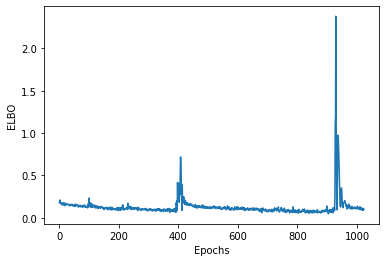

In [22]:
num_epochs = 1024
losses = []
pyro.clear_param_store()

epochs = tqdm.trange(num_epochs)
for epoch in epochs:
    try:
        running_loss = 0
        for (x_batch,) in dataloader:
            
            x_batch = x_batch[:, torch.randperm(30000)[:1024]]
#             loss = -flow.log_prob(x_batch[:, 0]).mean()
            
            log_prob = flow.log_prob(x_batch.view(-1, 2)).view(x_batch.shape[:-1])
            log_prob = torch.logsumexp(log_prob, dim=-1) - math.log(log_prob.shape[-1])
            loss = -log_prob.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses.append(running_loss)
        epochs.set_description("ELBO: {:.2f}".format(running_loss))
    except KeyboardInterrupt:
        plt.plot(losses);
        break
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("ELBO")
plt.show()

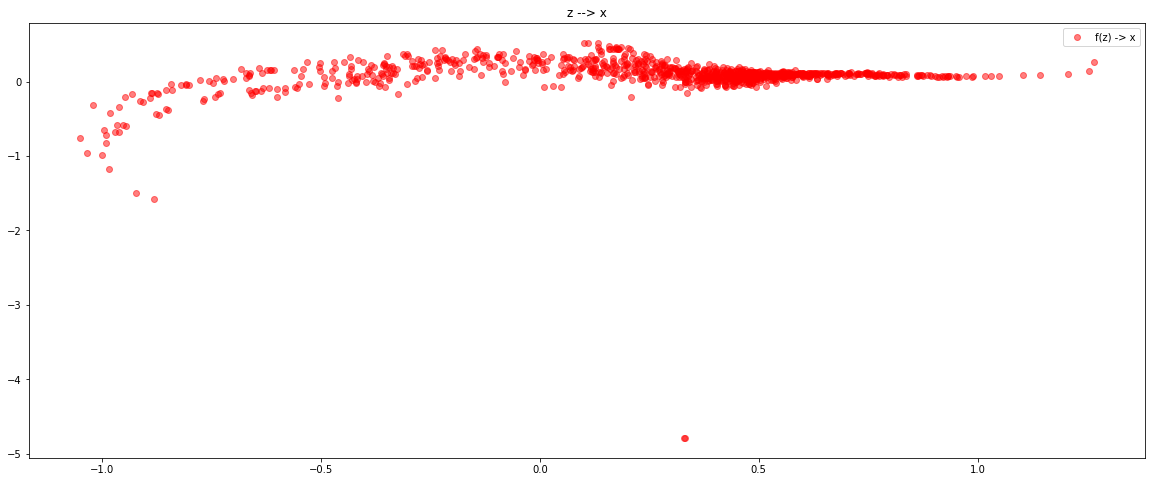

In [23]:
# Sample from trained NF
samples = flow.sample(num_samples=1000).detach()
fig = plt.figure(figsize=(20,8))
# plt.scatter(X_tensor[:, 0], X_tensor[:, 1], c="b", label="Data", alpha=0.8)
plt.scatter(samples[:, 0], samples[:, 1], c="r", alpha=0.5, label="f(z) -> x")
plt.title("z --> x")
plt.legend()

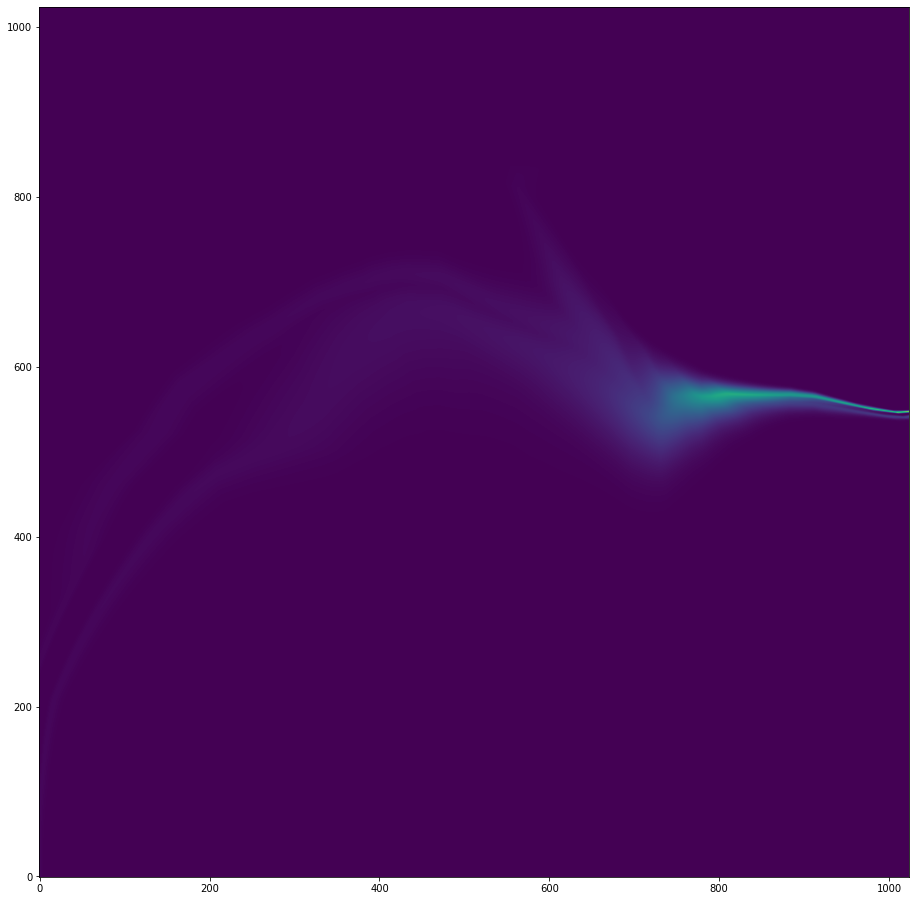

In [24]:
x = torch.linspace(-1, 1, 1024)
y = torch.linspace(-1, 1, 1024)

# x = torch.linspace(0, 4, 1024)


mesh = torch.stack(torch.meshgrid(y, x, indexing='xy')).view(2, -1).permute(1, 0)

p = flow.log_prob(mesh).exp()

p = p.view(1024, 1024)

plt.figure(figsize=(16, 16))
plt.imshow(p.detach().numpy(), origin='lower')

In [25]:
import seaborn as sns
# sns.kdeplot(X_tensor[:, 0])

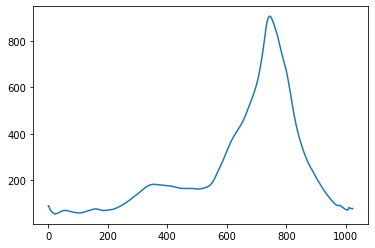

In [26]:
plt.plot(p.sum(0).detach())


In [27]:
import seaborn as sns
# sns.kdeplot(X_tensor[:, 1])

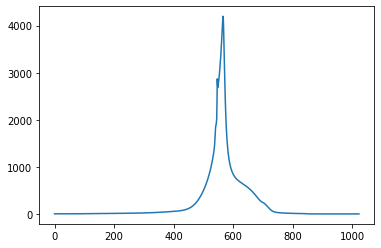

In [28]:
plt.plot(p.sum(1).detach())